In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm as tqdm
import warnings 
warnings.filterwarnings('ignore')
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima
import itertools
from sklearn.metrics import mean_squared_error as mse
from joblib import Parallel, delayed


In [2]:
df = pd.read_csv(r"data\model_input.csv")
dataset = df.drop(columns=["Unnamed: 0", "Min Temp", "Max Temp", "percentile_25", "percentile_75"])
dataset

,Mean Temp,RAINFALL,month_year,median
0,22.178833,0.085958,2013-04,0.455720
1,26.819516,0.413366,2013-05,0.665620
2,25.359833,31.586529,2013-06,0.226039
3,25.052258,20.653476,2013-07,0.249820
4,24.369032,24.446940,2013-08,0.267682
...,...,...,...,...
112,25.292838,13.266669,2022-08,0.238900
113,23.823002,11.473897,2022-09,0.244405
114,20.420344,3.875470,2022-10,0.419238
115,16.548313,0.000000,2022-11,0.518314


In [5]:
ts_dataset = dataset.drop(columns='month_year')
ts_dataset.rename(columns={'median': "Median NDSI"}, inplace=True)
ts_dataset

,Mean Temp,RAINFALL,Median NDSI
0,22.178833,0.085958,0.455720
1,26.819516,0.413366,0.665620
2,25.359833,31.586529,0.226039
3,25.052258,20.653476,0.249820
4,24.369032,24.446940,0.267682
...,...,...,...
112,25.292838,13.266669,0.238900
113,23.823002,11.473897,0.244405
114,20.420344,3.875470,0.419238
115,16.548313,0.000000,0.518314


In [43]:
target = ts_dataset["Median NDSI"]
exog = ts_dataset[["Mean Temp", "RAINFALL"]]

In [35]:
temp_result = adfuller(exog['Mean Temp'])
print("ADF Statistic:", temp_result[0])
print("p-value:", temp_result[1])

if temp_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -1.3002025817123515
p-value: 0.6290796272051388
The series is non-stationary. Differencing may be required.


In [36]:
temp_diff = exog['Mean Temp'].diff().dropna()
temp_result = adfuller(temp_diff)
print("ADF Statistic:", temp_result[0])
print("p-value:", temp_result[1])

if temp_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -10.91358497339599
p-value: 1.0814955491683104e-19
The series is stationary.


In [37]:
rain_result = adfuller(exog['RAINFALL'])
print("ADF Statistic:", rain_result[0])
print("p-value:", rain_result[1])

if rain_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -2.7960304268516785
p-value: 0.05884303439217425
The series is non-stationary. Differencing may be required.


In [39]:
rain_diff = exog['RAINFALL'].diff().dropna()
rain_result = adfuller(rain_diff)
print("ADF Statistic:", rain_result[0])
print("p-value:", rain_result[1])

if rain_result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -6.788368773733696
p-value: 2.39963208296417e-09
The series is stationary.


In [40]:
exog_diff = pd.DataFrame({
    'Mean Temp': temp_diff,
    'RAINFALL': rain_diff
})

In [44]:
target = target.iloc[1:]

In [45]:
print(target)

1      0.665620
2      0.226039
3      0.249820
4      0.267682
5      0.139340
         ...   
112    0.238900
113    0.244405
114    0.419238
115    0.518314
116    0.400156
Name: Median NDSI, Length: 116, dtype: float64


In [46]:
print(exog_diff)

     Mean Temp   RAINFALL
1     4.640683   0.327409
2    -1.459683  31.173162
3    -0.307575 -10.933053
4    -0.683226   3.793465
5    -0.407699 -17.127739
..         ...        ...
112   0.050664  -2.669182
113  -1.469836  -1.792772
114  -3.402658  -7.598428
115  -3.872032  -3.875470
116  -3.873498   0.000000

[116 rows x 2 columns]


In [7]:
result = adfuller(target)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -1.845308580329862
p-value: 0.3582103719315229
The series is non-stationary. Differencing may be required.


In [9]:
target_diff = target.diff().dropna()
result = adfuller(target_diff)
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] <= 0.05:
    print("The series is stationary.")
else:
    print("The series is non-stationary. Differencing may be required.")

ADF Statistic: -6.732153242922841
p-value: 3.2753347414858138e-09
The series is stationary.


In [ ]:
decomposition = seasonal_decompose(target, period=12, model='additive')

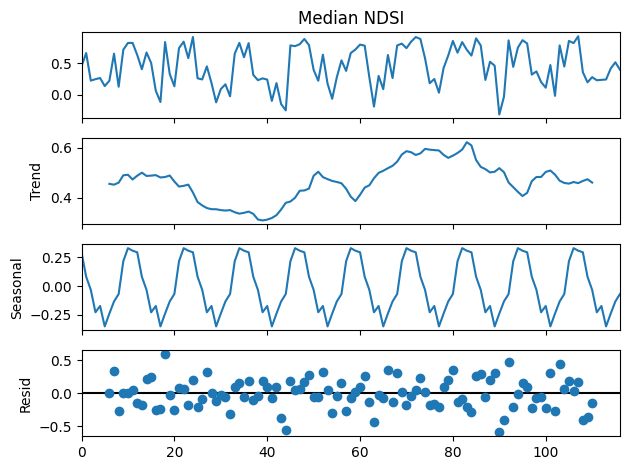

In [14]:
decomposition.plot();

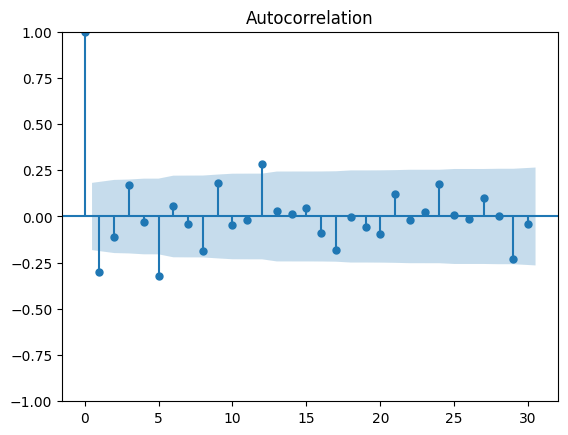

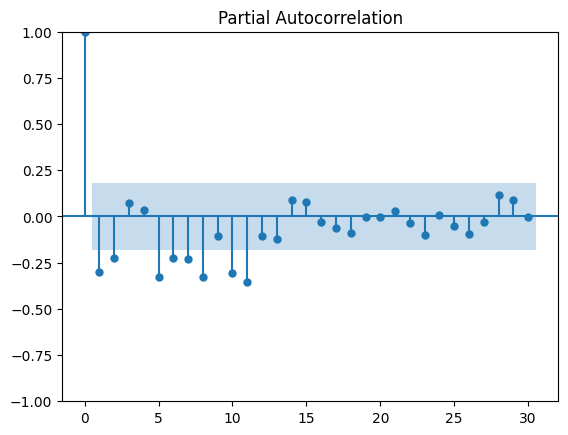

In [15]:
plot_acf(target_diff, lags=30)
plt.show()

plot_pacf(target_diff, lags=30)
plt.show()

In [47]:
train_target = target[:-12]
test_target = target[-12:]
train_exog = exog_diff[:-12]
test_exog = exog_diff[-12:]

In [60]:
model = auto_arima(train_target, exogenous=train_exog, seasonal=True, m=12, start_p=0, max_p=5,start_q=0, max_q=11, 
                   stepwise=False, trace=True, error_action='ignore', suppress_warnings=True, allow_insample=True)
print(model.summary())

 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=64.152, Time=0.02 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=41.876, Time=0.12 sec
 ARIMA(0,0,0)(0,0,2)[12] intercept   : AIC=31.804, Time=0.13 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=28.555, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=inf, Time=0.23 sec
 ARIMA(0,0,0)(1,0,2)[12] intercept   : AIC=27.717, Time=0.39 sec
 ARIMA(0,0,0)(2,0,0)[12] intercept   : AIC=26.360, Time=0.36 sec
 ARIMA(0,0,0)(2,0,1)[12] intercept   : AIC=27.552, Time=0.49 sec
 ARIMA(0,0,0)(2,0,2)[12] intercept   : AIC=29.560, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=49.409, Time=0.03 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=35.095, Time=0.08 sec
 ARIMA(0,0,1)(0,0,2)[12] intercept   : AIC=25.707, Time=0.21 sec
 ARIMA(0,0,1)(1,0,0)[12] intercept   : AIC=25.876, Time=0.12 sec
 ARIMA(0,0,1)(1,0,1)[12] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,0,1)(1,0,2)[12] intercept   : AIC=26.369, Time=0.57 sec
 ARIMA(0,0,1)(2,0,0)[12] interc

In [70]:
def run_SARIMAX(y, exog_diff, test_percent):
    num = int(test_percent*len(y)/100)
    train = y[:-num]
    test = y[-num:]
    train_exog = exog_diff[:-num]
    test_exog = exog_diff[-num:]
    model = SARIMAX(train, exog=train_exog, order=(2,0,2), seasonal_order=(0,0,1,12))
    model_fit = model.fit()
    model_pred = model_fit.predict(start = len(train), end = len(y)-1, exog=test_exog)
    rmse = np.sqrt(mse(test, model_pred))
    print("RMSE = ", rmse)

    plt.plot(y.index, y, c = 'orange')
    plt.plot(y.index, model_fit.predict(start=0,end=len(y)-1,exog=test_exog), c = 'cyan')
    plt.scatter(y.index, y, c = 'black')
    plt.scatter(y.index, model_fit.predict(start=0,end=len(y)-1,exog=test_exog), c = 'brown')
    plt.xlabel("Time")
    plt.ylabel("Median NDSI of Image")
    plt.title("Actual vs Prediction SARIMAX")
    plt.legend(["Actual", "Prediction"])
    plt.show()

RMSE =  0.19876707840527347


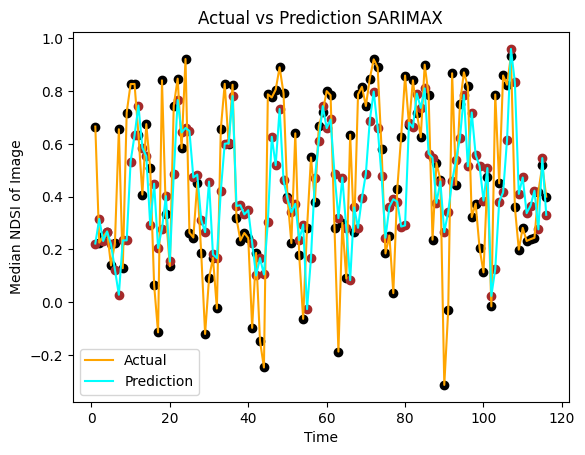

RMSE =  0.2767398951148774


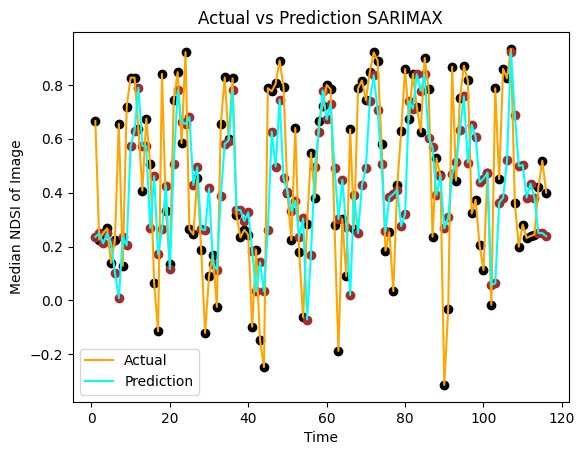

RMSE =  0.2847357733856464


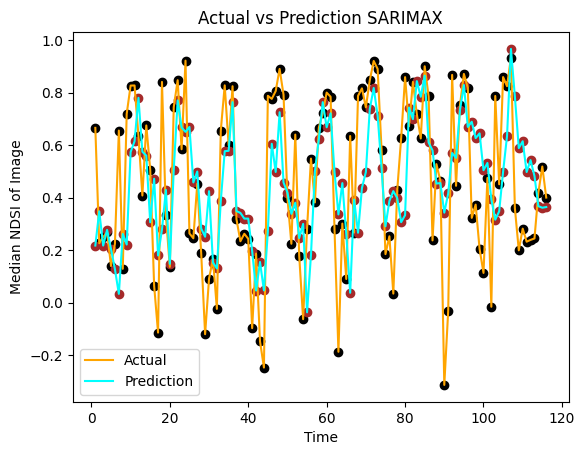

RMSE =  0.2728273320234429


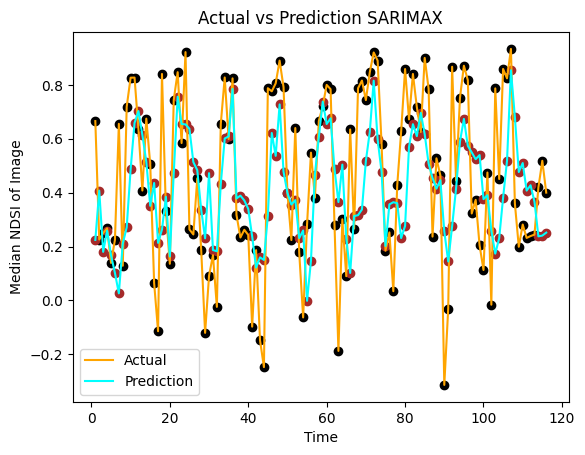

RMSE =  0.3075749532105649


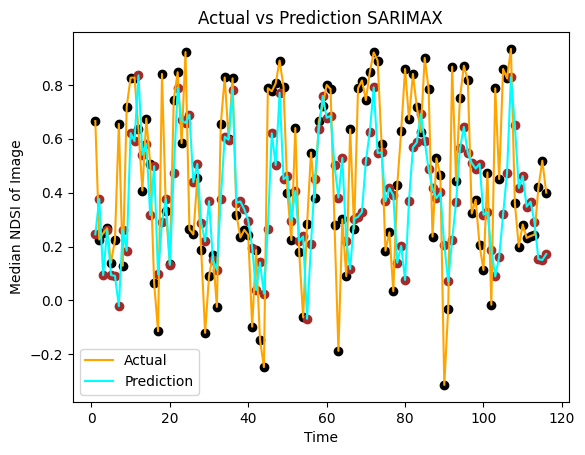

RMSE =  0.32290245286739006


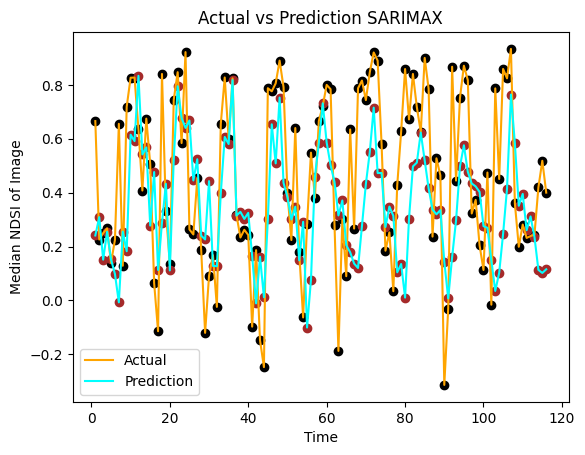

RMSE =  0.303587147578664


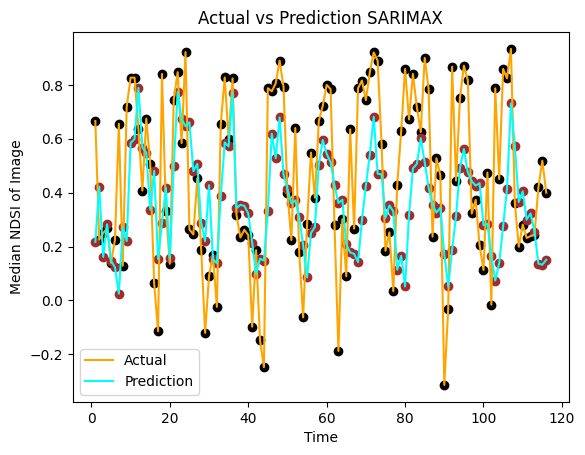

RMSE =  0.284516875315248


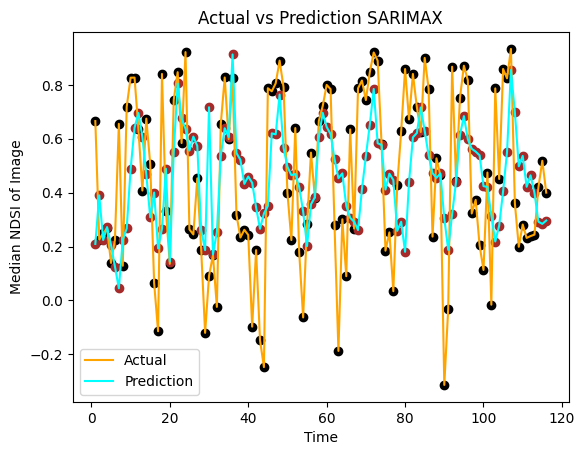

RMSE =  0.5834741753056814


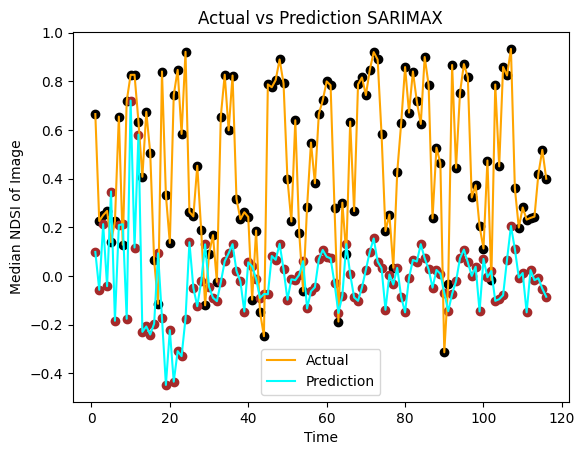

In [72]:
for i in range(10,100,10):
    run_SARIMAX(target, exog_diff, i)